In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import numpy as np

#### setting up 

In [ ]:
base_dir = os.path.abspath('../data/processed')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

IMG_SIZE = 150  # We force all images to this squared size (150x150): small enough but still detailed for our case
BATCH_SIZE = 32 # We feed 32 images at a time to the model: it's enough images to get a good "average" of what the data looks like.

print(f"Training on data from: {train_dir}")
print(f"Validating on data from: {val_dir}")

Training on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/train
Validating on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/val


### generators definition for proper training and evaluation

In [4]:


# Train with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (0-1)
    rotation_range=40,      # Twist up to 40 degrees
    width_shift_range=0.2,  # Move Left/Right 20%
    height_shift_range=0.2, # Move Up/Down 20%
    shear_range=0.2,        # Slant/Perspective distortion
    zoom_range=0.2,         # Zoom in/out 20%
    horizontal_flip=True,   # Mirror flip
    fill_mode='nearest'     # Fill gaps with neighbor color
)

# Validation;
val_datagen = ImageDataGenerator(rescale=1./255)

# load the data
# flow_from_directory looks at the folder directory and extracts images  atomatically assigning them the proper label given the 
# fact they belong to a certain subfolder (rock, paper or scissors)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading Training Data...
Found 1531 images belonging to 3 classes.
Loading Validation Data...
Found 326 images belonging to 3 classes.


## Model 1

#### Model specification

In [5]:
# Actual model set-up
model = models.Sequential([
    # Block 1: The Outline Detector (32 Filters)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    # Block 2: The Shape Detector (64 Filters)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Block 3: The Feature Detector (128 Filters)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Block 4: The Complex Pattern Detector (128 Filters)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten: Convert the 2D maps into a 1D list of numbers
    layers.Flatten(),
    
    # Dense: The Reasoning Layer
    layers.Dense(512, activation='relu'),
    
    # Output: The Answer (3 classes: Rock, Paper, Scissors)
    layers.Dense(3, activation='softmax') 
])

# Print a summary to check the architecture
model.summary()

/Users/paolominini/Projects/rps-cnn-classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

This is a standard 4-Layer Convolutional Network.
- The "Funnel" Design (32 $\rightarrow$ 64 $\rightarrow$ 128 $\rightarrow$ 128):
    -   Layer 1 (32 Filters): This layer is shallow. It only looks for simple "edges" and "colors" (e.g., the line where a finger meets the background). We use fewer filters (32) because there are only so many ways to draw a line.
    - Layers 3 & 4 (128 Filters): Deeper layers combine those lines into complex shapes (fingers, knuckles, fists). We need more filters (128) here because the combinations are much more complex.
- MaxPooling2D(2, 2): After every learning layer, we cut the image size in half (150 $\rightarrow$ 75 $\rightarrow$ 37...).Reason: This forces the AI to summarize. It stops caring about exactly which pixel a finger is on and starts caring that there is a finger in that general area. It also massively reduces the math required, preventing your computer from "exploding."
- Dense(512): This is the "Classifier." After the visual features are extracted, these 512 neurons act like a committee that votes on what those features mean.
- Dense(3, activation='softmax'): This is the final output. It must be 3 because we have 3 classes. Softmax turns the raw math scores into probabilities (e.g., "90% Rock, 5% Paper, 5% Scissors").

#### Compile the model using cross-entropy, adam as optimizer and accuracy to evaluate

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Model compiled and ready for training.")

Model compiled and ready for training.


##### early stopping and reduce LR on Plateau

In [7]:
# EarlyStopping: Stop if the model stops improving for 5 epochs (prevents wasting time)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: If the model gets stuck, lower the learning rate to help it find the "sweet spot" when the loss value doesn't decrese after 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Multiply LR by 0.2
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

#### Training

In [8]:
print("Starting training...")

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

Starting training...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step - accuracy: 0.4148 - loss: 1.0988 - val_accuracy: 0.6227 - val_loss: 0.7818 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 0.6519 - loss: 0.7669 - val_accuracy: 0.8650 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.7596 - loss: 0.5668 - val_accuracy: 0.9202 - val_loss: 0.2358 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.8034 - loss: 0.4784 - val_accuracy: 0.8558 - val_loss: 0.3053 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.8563 - loss: 0.3761 - val_accuracy: 0.9356 - val_loss: 0.1629 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.8674 - loss: 0.3544 - val_accuracy: 0.9724 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - accura

#### Plot the results

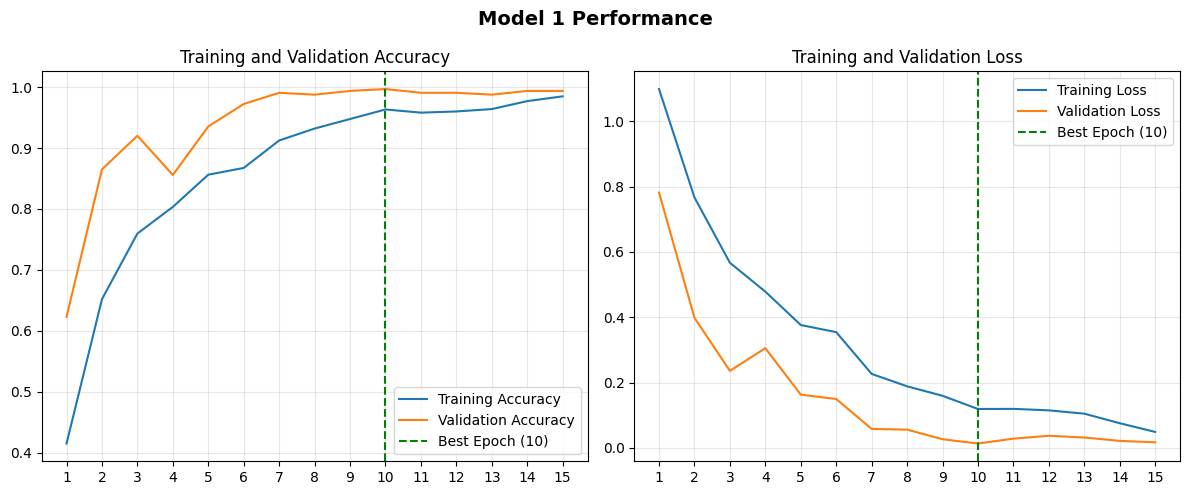

Best model was restored from Epoch 10 (Lowest Val Loss: 0.0132)


In [ ]:
# extract data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1) # Shift the range to start at 1 instead of 0

# Find best epoch and add 1 (to match the shifted range)
best_epoch_idx = val_loss.index(min(val_loss))
best_epoch = best_epoch_idx + 1

# actual plot
plt.figure(figsize=(12, 5))

# - accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xticks(epochs_range)

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True, alpha=0.3) 

# - loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')

# 3. FIX: Force the x-axis to show only our integer epochs
plt.xticks(epochs_range)

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)

plt.suptitle('Model 1 Performance', fontweight='bold', fontsize=14)
plt.tight_layout()

# Save and Show
save_path = os.path.abspath('../reports/figures/training_history_1.png')
plt.savefig(save_path)
plt.show()

# Print the final result cleanly
print(f"Best model was restored from Epoch {best_epoch} (Lowest Val Loss: {min(val_loss):.4f})")

The baseline model stopped at the 10th cycle (max_epoch = 20), achieving an exceptional validation accuracy of ~99.7%. To ensure optimal convergence, we also utilized adaptive training callbacks rather than static epochs. Around Epochs 11-13, the validation loss plateaued. As designed, the ReduceLROnPlateau callback detected this stagnation and dynamically reduced the learning rate from 0.001 to 0.0002 at Epoch 14. This adaptive scaling still didn't reach allow us to reac a better local minimum, so the model weights were restored from the end of the best epoch: 10.

urthermore, the persistent gap where validation accuracy exceeds training accuracy confirms that the rigorous data augmentation successfully prevented overfitting.

In [12]:
print(f"Validation accuracy value: {max(val_acc):.4f}")

Validation accuracy value: 0.9969


### Mistakes check

Found 326 images belonging to 3 classes.
Predicting on Validation Set...
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Total Errors: 1 out of 326 images


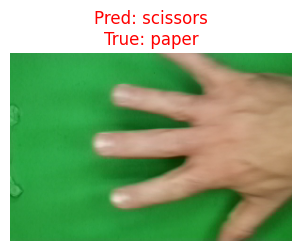

In [ ]:
# audit generator.
# We need this to match filenames to predictions 1-to-1
audit_datagen = ImageDataGenerator(rescale=1./255)
audit_generator = audit_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # the one thing different from the usual train and val_generators (in order to allow to recover the correct image)
)

# get predictions
print("Predicting on Validation Set...")
predictions = model.predict(audit_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = audit_generator.classes
class_labels = list(audit_generator.class_indices.keys()) # ['paper', 'rock', 'scissors']

# find errors
# Get the indices where Prediction doesn't match the true value
errors = np.where(predicted_classes != true_classes)[0]
print(f"Total Errors: {len(errors)} out of {len(true_classes)} images")

# plot the mistakes
if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    
    # We will show up to 10 errors
    num_to_show = min(10, len(errors))
    
    for i in range(num_to_show):
        error_index = errors[i]
        
        # Get the actual image file path
        image_path = audit_generator.filepaths[error_index]
        
        # Load and plot
        img = plt.imread(image_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        
        # Title: "Pred: Rock / True: Paper"
        pred_label = class_labels[predicted_classes[error_index]]
        true_label = class_labels[true_classes[error_index]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.abspath('../reports/figures/mistakes_1.png'))
    plt.show()
else:
    print("The model made zero mistakes on the validation set.")

We want to analyze the only mistake the model had on the validation set, that was a wrongfully classificate paper instance. The predicted class is "scissors": this may be due to the fact that the hand has wide spread fingers, and the area between them might have been captured by the model as a "scissors" instance.